In [6]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s',force_reload=True)
# model = torch.hub.load('','yolov5s',source='local')

# Image
img = 'https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg'

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672

Download error: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Exception: Cache maybe be out of date, try force_reload=True. See https://github.com/ultralytics/yolov5/issues/36 for help.

In [3]:
from test import *

In [1]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized


def detect(save_img=False):
    source, weights, view_img, save_txt, imgsz = opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size
    save_img = not opt.nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment=opt.augment)[0]

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t2 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)

            # Print time (inference + NMS)
            print(f'{s}Done. ({t2 - t1:.3f}s)')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')




In [14]:
model = torch.load('./weights/yolov5s.pt')
model

{'best_fitness': array([    0.37287]), 'epoch': -1, 'model': Model(
   (model): Sequential(
     (0): Focus(
       (conv): Conv(
         (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU()
       )
     )
     (1): Conv(
       (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU()
     )
     (2): C3(
       (cv1): Conv(
         (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU()
       )
       (cv2): Conv(
         (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True,

In [16]:
mm=model['model'].float().fuse().eval()

Fusing layers... 


Model Summary: 224 layers, 7266973 parameters, 0 gradients, 17.0 GFLOPS


In [24]:
for i in mm.parameters():
    print(i)
    break

Parameter containing:
tensor([[[[-2.73007e-01, -1.44108e+00, -1.18709e+00],
          [-3.13122e-01, -9.47540e-01, -7.23963e-01],
          [ 4.31564e-01,  2.05478e+00,  1.50800e+00]],

         [[ 4.42258e-02, -1.17188e+00, -8.76057e-01],
          [-1.95059e-01, -9.74917e-01, -6.32327e-01],
          [ 3.44871e-01,  1.78557e+00,  1.31561e+00]],

         [[ 7.90884e-02, -8.21303e-01, -5.11413e-01],
          [-1.49812e-01, -7.76816e-01, -4.33085e-01],
          [ 2.43539e-01,  1.37720e+00,  1.02891e+00]],

         ...,

         [[-7.77576e-01, -2.04717e+00, -3.48674e-01],
          [ 1.02378e-01,  3.53046e-01,  2.45060e-01],
          [ 7.43735e-01,  2.39395e+00,  4.36127e-01]],

         [[-5.63505e-01, -1.84337e+00, -1.81181e-01],
          [ 4.09939e-02,  2.64262e-01,  1.27758e-01],
          [ 4.28903e-01,  1.90269e+00,  9.71020e-02]],

         [[-2.87456e-01, -1.35135e+00,  5.96490e-02],
          [-8.60871e-03,  1.16161e-01,  6.17403e-02],
          [ 1.94394e-01,  1.41295e+

In [2]:
source = './data/images'
weights = './weights/yolov5s.pt'
view_img = False
save_txt = True
imgsz = 640
opt_nosave = False
save_img = not opt_nosave and not source.endswith('.txt')  # save inference images
save_img = True
webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
    ('rtsp://', 'rtmp://', 'http://', 'https://'))

# Directories
save_dir = Path(increment_path(Path('runs/detect') / 'exp', exist_ok=True))  # increment run
(save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

# Initialize
set_logging()
device = select_device('0')
half = device.type != 'cpu'  # half precision only supported on CUDA

# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(imgsz, s=stride)  # check img_size
if half:
    model.half()  # to FP16

# Second-stage classifier
classify = False
if classify:
    modelc = load_classifier(name='resnet101', n=2)  # initialize
    modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    
# Set Dataloader
vid_path, vid_writer = None, None
if webcam:
    view_img = check_imshow()
    cudnn.benchmark = True  # set True to speed up constant image size inference
    dataset = LoadStreams(source, img_size=imgsz, stride=stride)
else:
    dataset = LoadImages(source, img_size=imgsz, stride=stride)

# Get names and colors
names = model.module.names if hasattr(model, 'module') else model.names
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

# Run inference
if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once

YOLOv5 🚀 2021-4-17 torch 1.7.1+cu101 CUDA:0 (GeForce RTX 2080 Ti, 10989.4375MB)



Fusing layers... 


Model Summary: 224 layers, 7266973 parameters, 0 gradients, 17.0 GFLOPS


In [9]:
img.shape

torch.Size([3, 640, 480])

In [5]:
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    img = img.unsqueeze(0)
    pred = model(img, augment=True)[0]
    pred = non_max_suppression(pred, 0.25, 0.5, None, agnostic=True)
    for i, det in enumerate(pred):  # detections per image
        print(1111111111111)
        if webcam:  # batch_size >= 1
            p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
        else:
            p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

        p = Path(p)  # to Path
        save_path = str(save_dir / p.name)  # img.jpg
        txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
        s += '%gx%g ' % img.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh

        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Write results
            for *xyxy, conf, cls in reversed(det):
                if save_txt:  # Write to file
                    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                    line = (cls, *xywh, conf) if True else (cls, *xywh)  # label format
                    with open(txt_path + '.txt', 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')

                if save_img or view_img:  # Add bbox to image
                    label = f'{names[int(cls)]} {conf:.2f}'
                    plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
        # Print time (inference + NMS)
        print(f'{s}Done. ({1234 - 1111:.3f}s)')
        # Stream results
        if view_img:
            cv2.imshow(str(p), im0)
            # cv2.waitKey(1)  # 1 millisecond

        # Save results (image with detections)
        if save_img:
            if dataset.mode == 'image':
                cv2.imwrite(save_path, im0)
            else:  # 'video' or 'stream'
                if vid_path != save_path:  # new video
                    vid_path = save_path
                    if isinstance(vid_writer, cv2.VideoWriter):
                        vid_writer.release()  # release previous video writer
                    if vid_cap:  # video
                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    else:  # stream
                        fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path += '.mp4'
                    vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                vid_writer.write(im0)

image 1/2 /remote-home/zwli/ObjDetect/yolov5/data/images/bus.jpg: 1111111111111
640x480 4 persons, 1 bus, 1 fire hydrant, 1 skateboard, Done. (123.000s)
image 2/2 /remote-home/zwli/ObjDetect/yolov5/data/images/zidane.jpg: 1111111111111
384x640 3 persons, 2 ties, Done. (123.000s)


In [4]:
for i, det in enumerate(pred):  # detections per image
    print(1111111111111)
    if webcam:  # batch_size >= 1
        p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
    else:
        p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

    p = Path(p)  # to Path
    save_path = str(save_dir / p.name)  # img.jpg
    txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
    s += '%gx%g ' % img.shape[2:]  # print string
    gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
    
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

        # Print results
        for c in det[:, -1].unique():
            n = (det[:, -1] == c).sum()  # detections per class
            s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

        # Write results
        for *xyxy, conf, cls in reversed(det):
            if save_txt:  # Write to file
                xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                line = (cls, *xywh, conf) if True else (cls, *xywh)  # label format
                with open(txt_path + '.txt', 'a') as f:
                    f.write(('%g ' * len(line)).rstrip() % line + '\n')

            if save_img or view_img:  # Add bbox to image
                label = f'{names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
    # Print time (inference + NMS)
    print(f'{s}Done. ({1234 - 1111:.3f}s)')
    # Stream results
    if view_img:
        cv2.imshow(str(p), im0)
        # cv2.waitKey(1)  # 1 millisecond

    # Save results (image with detections)
    if save_img:
        if dataset.mode == 'image':
            cv2.imwrite(save_path, im0)
        else:  # 'video' or 'stream'
            if vid_path != save_path:  # new video
                vid_path = save_path
                if isinstance(vid_writer, cv2.VideoWriter):
                    vid_writer.release()  # release previous video writer
                if vid_cap:  # video
                    fps = vid_cap.get(cv2.CAP_PROP_FPS)
                    w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                else:  # stream
                    fps, w, h = 30, im0.shape[1], im0.shape[0]
                    save_path += '.mp4'
                vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
            vid_writer.write(im0)

1111111111111
640x480 4 persons, 1 bus, 1 fire hydrant, 1 skateboard, Done. (123.000s)


In [5]:
label

NameError: name 'label' is not defined

In [1]:
t0 = time.time()
for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.25, 0.5, None, agnostic=True)
    t2 = time_synchronized()

    # Apply Classifier
    if classify:
        pred = apply_classifier(pred, modelc, img, im0s)

    # Process detections
    for i, det in enumerate(pred):  # detections per image
        if webcam:  # batch_size >= 1
            p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
        else:
            p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

        p = Path(p)  # to Path
        save_path = str(save_dir / p.name)  # img.jpg
        txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
        s += '%gx%g ' % img.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Write results
            for *xyxy, conf, cls in reversed(det):
                if save_txt:  # Write to file
                    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                    line = (cls, *xywh, conf) if True else (cls, *xywh)  # label format
                    with open(txt_path + '.txt', 'a') as f:
                        f.write(('%g ' * len(line)).rstrip() % line + '\n')

                if save_img or view_img:  # Add bbox to image
                    label = f'{names[int(cls)]} {conf:.2f}'
                    plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)

        # Print time (inference + NMS)
        print(f'{s}Done. ({t2 - t1:.3f}s)')

        # Stream results
        if view_img:
            cv2.imshow(str(p), im0)
            cv2.waitKey(1)  # 1 millisecond

        # Save results (image with detections)
        if save_img:
            if dataset.mode == 'image':
                cv2.imwrite(save_path, im0)
            else:  # 'video' or 'stream'
                if vid_path != save_path:  # new video
                    vid_path = save_path
                    if isinstance(vid_writer, cv2.VideoWriter):
                        vid_writer.release()  # release previous video writer
                    if vid_cap:  # video
                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    else:  # stream
                        fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path += '.mp4'
                    vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                vid_writer.write(im0)

if save_txt or save_img:
    s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
    print(f"Results saved to {save_dir}{s}")

print(f'Done. ({time.time() - t0:.3f}s)')

NameError: name 'time' is not defined

In [15]:
from PIL import Image

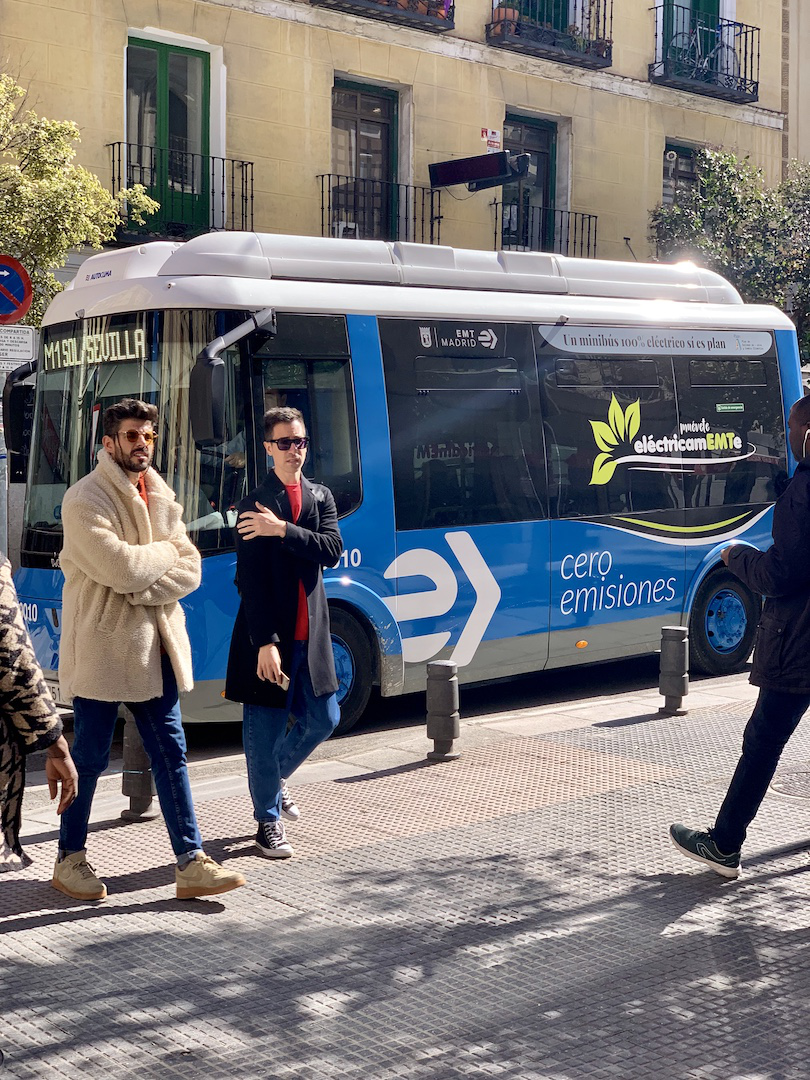

In [16]:
Image.open('./data/images/bus.jpg')